## **라이브러리 로드 및 랜덤시드 고정**

In [ ]:
!pip install torchmetrics -q
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from torchmetrics import MeanAbsolutePercentageError

In [ ]:
random_seed = 222
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # multi-GPU

## **데이터 전처리 및 로드**

In [ ]:
def generate_target_df(weather_metadata_path, weather_5minute_ASOS_path, holiday_path, power_path):

  import pandas as pd

  # 기상관측 MetaData 불러오기
  weather_metadata = pd.read_csv(weather_metadata_path)
  STN_dict = {STN_name : STN_num for STN_num, STN_name in zip(weather_metadata['지점'], weather_metadata['지점명'])}
  target_STN_list = [STN_dict[STN_name] for STN_name in ['서울', '부산', '인천', '대구', '대전', '광주', '원주']]

  # 서울 포함 7개 도시의 기온 및 일사량 데이터 불러오기
  weather_5minute = pd.read_parquet(weather_5minute_ASOS_path).astype({'지점' : 'int'})
  weather_5minute = weather_5minute[weather_5minute['지점'].isin(target_STN_list)]
  weather_5minute = weather_5minute[['지점', '일시', '기온(°C)', '일사(MJ/m^2)']]
  weather_5minute.columns = ['지점', '일시', '기온', '일사']

  column_list = ['기온', '일사']

  # 선형보간법 사용하여 결측값 채우기
  for idx, STN in enumerate(target_STN_list):

      # ① 각 STN별로 데이터 나누기
      tmp = weather_5minute[weather_5minute['지점'] == STN]

      # ② 시간순으로 정렬하기
      tmp = tmp.sort_values(by='일시')

      # ③ 선형보간법을 사용하여 nan값 채우기                
      for column in column_list:
        tmp[column] = tmp[column].interpolate(method='linear')

      # ④ tmp 합치기
      if idx == 0:
        interpolated_weather = tmp
      else:
        interpolated_weather = pd.concat([interpolated_weather, tmp])

  # 전국 기상 대표값 정하기 (최고기온, 최저기온, 평균일사량)
  for idx, column in enumerate(column_list):
    if column == '기온':
      # 최고 기온
      tmp_1 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].max()).rename(columns = {'기온' : 'max_temp'})
      # 최저 기온
      tmp_2 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].min()).rename(columns = {'기온' : 'min_temp'})
      tmp = pd.merge(tmp_1, tmp_2, on = '일시', how = 'inner')
    else:
      # 평균 일사량
      tmp = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].mean()).rename(columns = {'일사' : 'mean_insolation'})
    # ② groupby 결과를 인덱스 기준으로 Join
    if idx == 0:
      representative_weather = tmp
    else:
      representative_weather = pd.merge(representative_weather, tmp, on = '일시', how = 'inner')

  representative_weather.rename(columns = {'일시' : 'datetime'}, inplace= True)

  # 요일 특성 반영 (더미변수로 반영)
  # 0 : 월요일, 1 : 화요일 ~ 금요일, 2 : 토요일, 3 : 일요일

  representative_weather['weekday'] = pd.to_datetime(representative_weather['datetime']).dt.weekday
  representative_weather.replace({'weekday' : {2 : 1, 3 : 1, 4 : 1, 5 : 2, 6 : 3}}, inplace = True)
  representative_weather = pd.get_dummies(representative_weather, columns = ['weekday'])
                                          
  # 휴일 유형에 맞춘 더미변수 반영

  holiday = pd.read_csv(holiday_path)

  for dateName in ['국회의원선거일', '대통령선거일', '동시지방선거일', '전국동시지방선거', '제21대 국회의원선거']:
    holiday.replace({'dateName' : {dateName : '선거일'}}, inplace = True)
  holiday.replace({'dateName' : {'1월1일' : '신정'}}, inplace = True)
  holiday.replace({'dateName' : {'부처님오신날' : '석가탄신일'}}, inplace = True)
  holiday.replace({'dateName' : {'어린이 날' : '어린이날'}}, inplace = True)
  holiday.replace({'dateName' : {'대체휴무일' : '대체공휴일'}}, inplace = True)
  holiday.replace({'dateName' : {'임시공휴일' : '대체공휴일'}}, inplace = True)

  nameToNumber = {dateName : idx + 1  for idx, dateName in enumerate(list(holiday['dateName'].unique()))}
  holiday.replace({'dateName' : nameToNumber}, inplace = True)
  holiday_dict = {locdate : dateName for dateName, locdate in zip(holiday['dateName'], holiday['locdate'])}

  for row_number in range(representative_weather.shape[0]):
    if representative_weather.at[row_number, 'datetime'][:-6] in list(holiday['locdate']):
      representative_weather.at[row_number, 'holiday'] = holiday_dict[representative_weather.at[row_number, 'datetime'][:-6]]
    else:
      representative_weather.at[row_number, 'holiday'] = 0

  representative_weather = pd.get_dummies(representative_weather, columns = ['holiday'])

  # 월, 시간 정보 반영 (더미변수로 반영)

  representative_weather['month'] = pd.to_datetime(representative_weather['datetime']).dt.month
  representative_weather = pd.get_dummies(representative_weather, columns = ['month'])
  representative_weather['hour'] = pd.to_datetime(representative_weather['datetime']).dt.hour
  representative_weather = pd.get_dummies(representative_weather, columns = ['hour'])

  # 전력정보 불러오기

  power = pd.read_parquet(power_path)
  power['load'] = power['demand']
  power.drop(columns='demand', inplace = True)
  power.reset_index(inplace = True)
  power = power.astype({'datetime' : 'str'})
  for row_number in range(power.shape[0]):
    power.loc[row_number, 'datetime'] = power.loc[row_number, 'datetime'][:-3]

  # 기상정보, 달력정보, 전력정보를 하나의 데이터 프레임으로 합치기

  target_df = pd.merge(representative_weather, power, on = 'datetime', how = 'inner')[:-288]
  target_df = pd.concat([target_df.iloc[:, :4], target_df.iloc[:, -12:-1], target_df.iloc[:, 4:-12], target_df.iloc[:, -1]], axis = 1)

  return target_df

In [ ]:
# 타겟 데이터 생성 및 학습/검증/테스트 데이터 분리하기

weather_metadata_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/weather_localcenter_metadata.csv'
weather_5minute_ASOS_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/ASOS (2020-2023)/weather_5minute_ASOS_2020-2023.parquet'
holiday_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/time/holidays.csv'
power_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/load_supply/power_demand_moving_avg_added.parquet'

target_df = generate_target_df(weather_metadata_path, weather_5minute_ASOS_path, holiday_path, power_path)

train_df = target_df.iloc[:-8064,:]
valid_df = target_df.iloc[-8064:-2016,:]
test_df = target_df.iloc[-4032:,:]

## **데이터셋 로더, 모델 코드, 추론 코드 및 그래프**

### **CustomDataset Class 및 Scaler 생성**

In [ ]:
# Train 데이터셋을 위한 Custom Dataset은 Scaler의 fit_transform 기능을 이용

class CustomDatasetForTrain(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    self.dataset_tensor =torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.fit_transform(target_df.iloc[:,1:binary_var_start_number])),
                                                               target_df.iloc[:,binary_var_start_number:-1],
                                                               pd.DataFrame(scaler_for_Y.fit_transform(np.array(target_df['load']).reshape(-1, 1)))], axis = 1))).cuda()                           
    self.data_size = ((self.dataset_tensor.shape[0] - step_len - seq_len) // stride) + 1
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride
  
  def __len__(self):
    return self.data_size
  
  def __getitem__(self, idx):
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :],\
           self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]

# Test 데이터셋을 위한 Custom Dataset은 Scaler의 Transform 기능을 이용

class CustomDatasetForValTest(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    self.dataset_tensor =torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.transform(target_df.iloc[:,1:binary_var_start_number])),
                                                               target_df.iloc[:,binary_var_start_number:-1].reset_index(drop = True),
                                                               pd.DataFrame(scaler_for_Y.transform(np.array(target_df['load']).reshape(-1, 1)))], axis = 1))).cuda()                           
    self.data_size = ((self.dataset_tensor.shape[0] - step_len - seq_len) // stride)+1
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride
  
  def __len__(self):
    return self.data_size
  
  def __getitem__(self, idx):
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :],\
           self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]

# Scaler 객체 생성
ss_1 = MinMaxScaler() # Scaler for X
ss_2 = MinMaxScaler() # Scaler for y

### **모델 정의**

#### **Vanilla LSTM**

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
    )
  
  def forward(self, x):
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

#### **CNN + Bidirectional LSTM**

In [ ]:
class CNN_BILSTM(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers):
    super(CNN_BILSTM, self).__init__()
    # 입력인자 정의
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    # 합성곱 Layer 정의
    self.conv1d = nn.Conv1d(in_channels = self.in_channels, 
                            out_channels = self.out_channels,
                            kernel_size = self.kernel_size, 
                            padding = 'same')
    # LSTM Layer 정의
    self.lstm = nn.LSTM(self.out_channels, 
                        self.hidden_dim, 
                        num_layers = self.layers, 
                        batch_first = True, 
                        bidirectional = True)
    # 완전연결층 정의
    self.fc = nn.Linear(hidden_dim * 2, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
  
  # 결과값 계산
  def forward(self, x):
    x = torch.transpose(x, 1, 2)
    x = self.conv1d(x)
    x = torch.transpose(x, 1, 2)
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

#### **CNN + Bidirectional GRU**

In [ ]:
class CNN_BIGRU(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers):
    super(CNN_BIGRU, self).__init__()
    # 입력인자 정의
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    # 합성곱 Layer 정의
    self.conv1d = nn.Conv1d(in_channels = self.in_channels, 
                            out_channels = self.out_channels,
                            kernel_size = self.kernel_size, 
                            padding = 'same')
    # GRU Layer 정의
    self.lstm = nn.GRU(self.out_channels, 
                       self.hidden_dim, 
                       num_layers = self.layers, 
                       batch_first = True, 
                       bidirectional = True)
    # 완전연결층 정의
    self.fc = nn.Linear(hidden_dim * 2, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
  
  # 결과값 계산
  def forward(self, x):
    x = torch.transpose(x, 1, 2)
    x = self.conv1d(x)
    x = torch.transpose(x, 1, 2)
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

### **학습 함수 정의**

In [ ]:
# 모델 학습 함수 만들기

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  nb_epochs = num_epochs
  mean_abs_percentage_error = MeanAbsolutePercentageError().to(device)

  # epoch마다 loss 저장
  train_hist = np.zeros(nb_epochs)
  output = []
  
  for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(train_df)
    for batch_idx, samples in enumerate(train_df):
      x_train, y_train = samples
      # seq별 hidden state reset
      model.reset_hidden_state()
      # H(x) 계산
      outputs = model(x_train)
      # cost 계산
      loss = mean_abs_percentage_error(outputs, y_train)
      # cost로 H(x) 개선
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_cost += loss/total_batch 

    train_hist[epoch] = avg_cost

    if epoch % verbose == 0:
      print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
    # patience번째 마다 early stopping 여부 확인
    if (epoch % patience == 0) & (epoch != 0):
      if train_hist[epoch-patience] < train_hist[epoch]:
        print('\n Early Stopping')
        break
  
  return model.eval(), train_hist

### **모델 학습, 검증 및 테스트**

#### **Dataloader 생성**

In [ ]:
# CustomDataset 파라미터 설정 (시퀀스의 길이, 스텝 사이즈)
seq_len = 2016 # 시퀀스의 길이
step_len = 2016 # 스텝 사이즈

# 데이터셋 생성
train_dataset = CustomDatasetForTrain(train_df, 15, ss_1, ss_2, seq_len, step_len, stride = 1)
valid_dataset = CustomDatasetForValTest(valid_df, 15, ss_1, ss_2, seq_len, step_len, stride = 1)
test_dataset = CustomDatasetForValTest(test_df, 15, ss_1, ss_2, seq_len, step_len, stride = 1)

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size = 256, shuffle = True, drop_last = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 1, shuffle = False, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False, drop_last = True)

#### **모델 학습**

In [ ]:
# 모델 하이퍼 파라미터 설정

in_channels = 69 # 입력 컬럼의 개수
out_channels = 116 # 합성곱 필터로 생성될 out의 Dimension = 필터의 개수
kernel_size = 5 # 합성곱 필터의 커널의 크기
hidden_dim = 288 # 은닉 상태의 개수
layers = 3 # LSTM 혹은 GRU Layer의 개수
learning_rate = 0.0001 # 학습률
nb_epochs = 50 # 에포크의 수

In [ ]:
# Vanilla LSTM

lstm = LSTM(in_channels, hidden_dim, seq_len, step_len, layers).to(device)
lstm, lstm_hist = train_model(lstm, train_dataloader, num_epochs = nb_epochs,
                              lr = learning_rate, verbose = 1, patience = 4)

In [ ]:
# CNN + Bidirectional LSTM

cnn_bilstm = CNN_BILSTM(in_channels, out_channels, kernel_size, hidden_dim, seq_len, step_len, layers).to(device)
cnn_bilstm, cnn_bilstm_hist = train_model(cnn_bilstm, train_dataloader, num_epochs = nb_epochs,
                                          lr = learning_rate, verbose = 1, patience = 4)

In [ ]:
# CNN + Bidirecitonal GRU

cnn_bigru = CNN_BIGRU(in_channels, out_channels, kernel_size, hidden_dim, seq_len, step_len, layers).to(device)
cnn_bigru, cnn_bigru_hist = train_model(cnn_bigru, train_dataloader, num_epochs = nb_epochs,
                                        lr = learning_rate, verbose = 1, patience = 4)
torch.save(cnn_bigru, '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/modeling/모델링 결과/model_20230601_CNN-BIGRU.pth')

Epoch: 0000 train loss : 0.4626
Epoch: 0001 train loss : 0.3911
Epoch: 0002 train loss : 0.3475
Epoch: 0003 train loss : 0.2951
Epoch: 0004 train loss : 0.2545
Epoch: 0005 train loss : 0.2422
Epoch: 0006 train loss : 0.2198
Epoch: 0007 train loss : 0.2015
Epoch: 0008 train loss : 0.1956
Epoch: 0009 train loss : 0.1815
Epoch: 0010 train loss : 0.1714
Epoch: 0011 train loss : 0.1714
Epoch: 0012 train loss : 0.1648
Epoch: 0013 train loss : 0.1625
Epoch: 0014 train loss : 0.1537
Epoch: 0015 train loss : 0.1747
Epoch: 0016 train loss : 0.1431
Epoch: 0017 train loss : 0.1432
Epoch: 0018 train loss : 0.1361
Epoch: 0019 train loss : 0.1354
Epoch: 0020 train loss : 0.1266
Epoch: 0021 train loss : 0.1290
Epoch: 0022 train loss : 0.1177
Epoch: 0023 train loss : 0.1216
Epoch: 0024 train loss : 0.1109
Epoch: 0025 train loss : 0.1091
Epoch: 0026 train loss : 0.1031
Epoch: 0027 train loss : 0.1093
Epoch: 0028 train loss : 0.0999
Epoch: 0029 train loss : 0.0983
Epoch: 0030 train loss : 0.1346
Epoch: 0

#### **모델 검증 및 테스트**

In [ ]:
# 모델 검증

with torch.no_grad():
  
  # 예측값과 실제값을 담을 빈 리스트 준비하기

  cnn_bigru_pred_list_val = []
  true_list_val = []

  for X, y in valid_dataloader:

    # 데이터 로더에서 테스트 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)

    # 모델별 예측값 계산
    cnn_bigru_pred = cnn_bigru(X)

    # 모델별 예측값 및 실제값을 리스트에 넣어주기
    cnn_bigru_pred_list_val.append(ss_2.inverse_transform(cnn_bigru_pred.cpu().detach().numpy()))
    true_list_val.append(ss_2.inverse_transform(y.cpu().detach().numpy()))

# 위에서 완성된 예측값, 실제값 리스트로 평균 MAPE 계산하기
cnnbigru_MAPE_list_val = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnn_bigru_pred_list_val, true_list_val)]

# 모델별 평균 MAPE 출력하기
print('CNN + Bi-GRU 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnnbigru_MAPE_list_val)/len(cnnbigru_MAPE_list_val) * 100, 3)))

CNN + Bi-GRU 모델의 평균 검증 MAPE는 3.371% 입니다


In [ ]:
# 모델 테스트

with torch.no_grad():
  
  # 예측값과 실제값을 담을 빈 리스트 준비하기

  cnn_bigru_pred_list_test = []
  true_list_test = []

  for X, y in test_dataloader:

    # 데이터 로더에서 테스트 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)

    # 모델별 예측값 계산
    cnn_bigru_pred = cnn_bigru(X)

    # 모델별 예측값 및 실제값을 리스트에 넣어주기
    cnn_bigru_pred_list_test.append(ss_2.inverse_transform(cnn_bigru_pred.cpu().detach().numpy()))
    true_list_test.append(ss_2.inverse_transform(y.cpu().detach().numpy()))

# 위에서 완성된 예측값, 실제값 리스트로 평균 MAPE 계산하기
cnnbigru_MAPE_list_test = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnn_bigru_pred_list_test, true_list_test)]

# 모델별 평균 MAPE 출력하기
print('CNN + Bi-GRU 모델의 평균 테스트 MAPE는 {}% 입니다'.format(round(sum(cnnbigru_MAPE_list_test)/len(cnnbigru_MAPE_list_test) * 100, 3)))

CNN + Bi-GRU 모델의 평균 테스트 MAPE는 2.734% 입니다


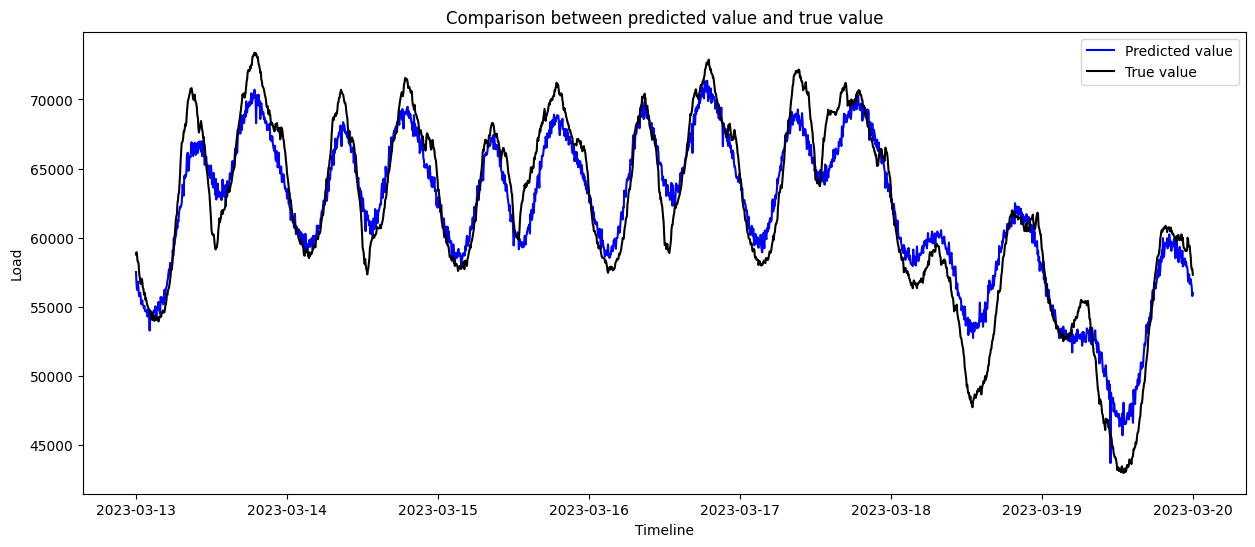

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 6))
plt.title('Comparison between predicted value and true value')
plt.plot(pd.date_range('2023-03-13 00:00', '2023-03-19 23:55', freq = '5min'), cnn_bigru_pred_list_test[0][0], color = 'blue')
plt.plot(pd.date_range('2023-03-13 00:00', '2023-03-19 23:55', freq = '5min'), true_list_test[0][0], color = 'black')
plt.legend(['Predicted value', 'True value'])
plt.xlabel('Timeline')
plt.ylabel('Load')
plt.show()